In [23]:
#Imports
import pandas as pd
import os
from google.cloud import bigquery
from datetime import datetime, date, timedelta
import re
import calendar
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from prophet import Prophet
import holidays
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'

from pathlib import Path 

In [2]:
#Bigquery credentials/Date transformations
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\Greg\OneDrive - Consumer Edge Research LLC\Desktop\Python\gcp-key-2.json"
#C:\Users\Greg\AppData\Local\Programs\Python\Python39\gcp-key-2.json
#C:\Users\Greg\OneDrive - Consumer Edge Research LLC\Desktop\Python\gcp-key-2.json
client = bigquery.Client()

#Trans_date transformations
def date_transf(df):
    df['trans_date_dt'] = pd.to_datetime(df['trans_date'], format = "%Y-%m-%d", errors = 'coerce')
    df['year'] = df['trans_date_dt'].dt.year.astype(str)
    df['month'] = df['trans_date_dt'].dt.month.apply(lambda x: calendar.month_abbr[x])
    df['norm_date'] = df['trans_date_dt'].dt.strftime("%m/%d/%Y")
    df['period'] = df['trans_date_dt'].dt.to_period('Q')
    df['norm_date_ya'] = df['norm_date'].shift(364)

In [3]:
#error metrics
def mape(ground_truth, prediction):
    ground_truth, prediction = np.array(ground_truth), np.array(prediction)
    return np.mean(np.abs((ground_truth-prediction) / ground_truth)) * 100

In [4]:
raw_hist_sql = 'SELECT segment_name, brand_name, trans_date, weekday, day_of_year, weeknum, calendar_week, calendar_qtr, bank_holiday_flag, major_holiday_flag, cardtype, spend_amount_usd, trans_count FROM `beta-omega-alpha-theta.apollo_us_cube_daily_signal.day_sym_seg_brand_cardtype_emax` emax LEFT JOIN `beta-omega-alpha-theta.reference.calendar` cal ON emax.trans_date = cal.date where segment_name = "TXRH (US)" order by brand_name, trans_date, cardtype DESC'
raw_hist_df = client.query(raw_hist_sql).to_dataframe()

raw_hist_df['qtr_num'] = raw_hist_df['calendar_qtr'].str[-2:]
raw_hist_df['trans_date'] = pd.to_datetime(raw_hist_df['trans_date'], format = "%Y-%m-%d", errors = 'coerce')
raw_hist_df.set_index('trans_date', inplace = True)

In [5]:
raw_hist_df.dtypes

segment_name           object
brand_name             object
weekday                object
day_of_year             Int64
weeknum                 Int64
calendar_week          object
calendar_qtr           object
bank_holiday_flag       Int64
major_holiday_flag      Int64
cardtype               object
spend_amount_usd      float64
trans_count           float64
qtr_num                object
dtype: object

In [6]:
txrh_credit_spend = raw_hist_df[(raw_hist_df['cardtype'] == 'CREDIT') & (raw_hist_df['brand_name'] == 'TEXAS ROADHOUSE')]

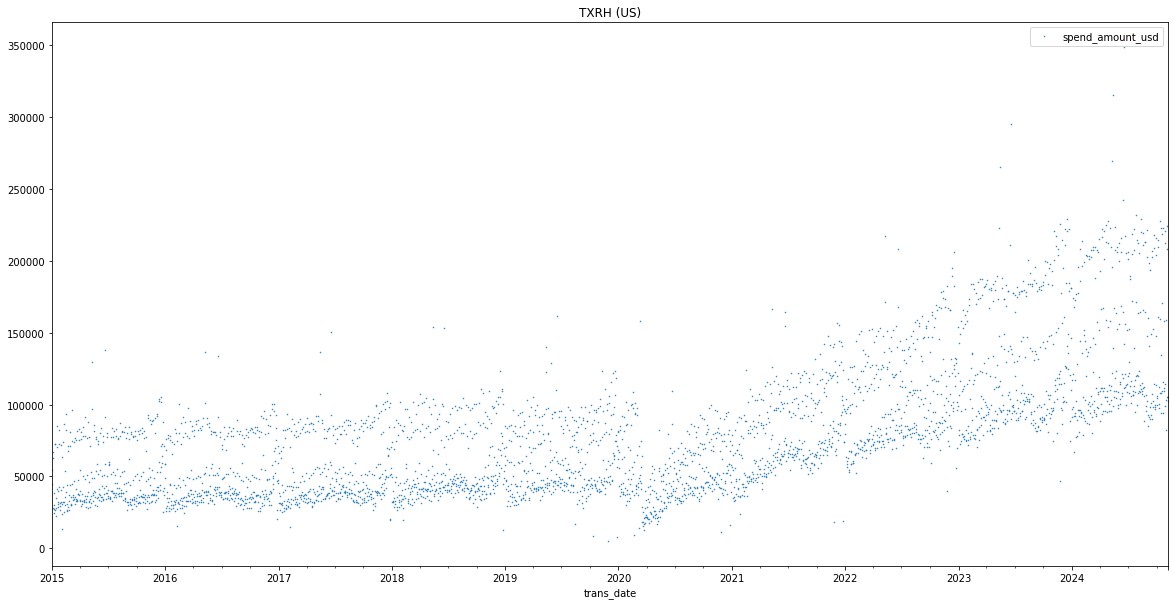

In [7]:
color_pal = sns.color_palette()
txrh_credit_spend.plot(style = '.',
                 y='spend_amount_usd',
                 figsize =(20,10),
                 ms=1,
                 color=color_pal[0],
                 title = 'TXRH (US)',
                )

plt.show()

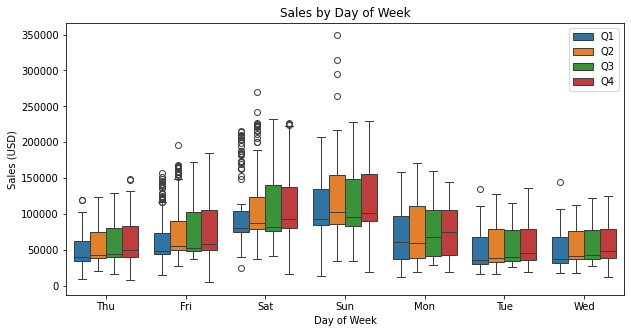

In [8]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(data = txrh_credit_spend,
            x='weekday',
            y='spend_amount_usd',
            hue='qtr_num')
ax.set_title('Sales by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales (USD)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

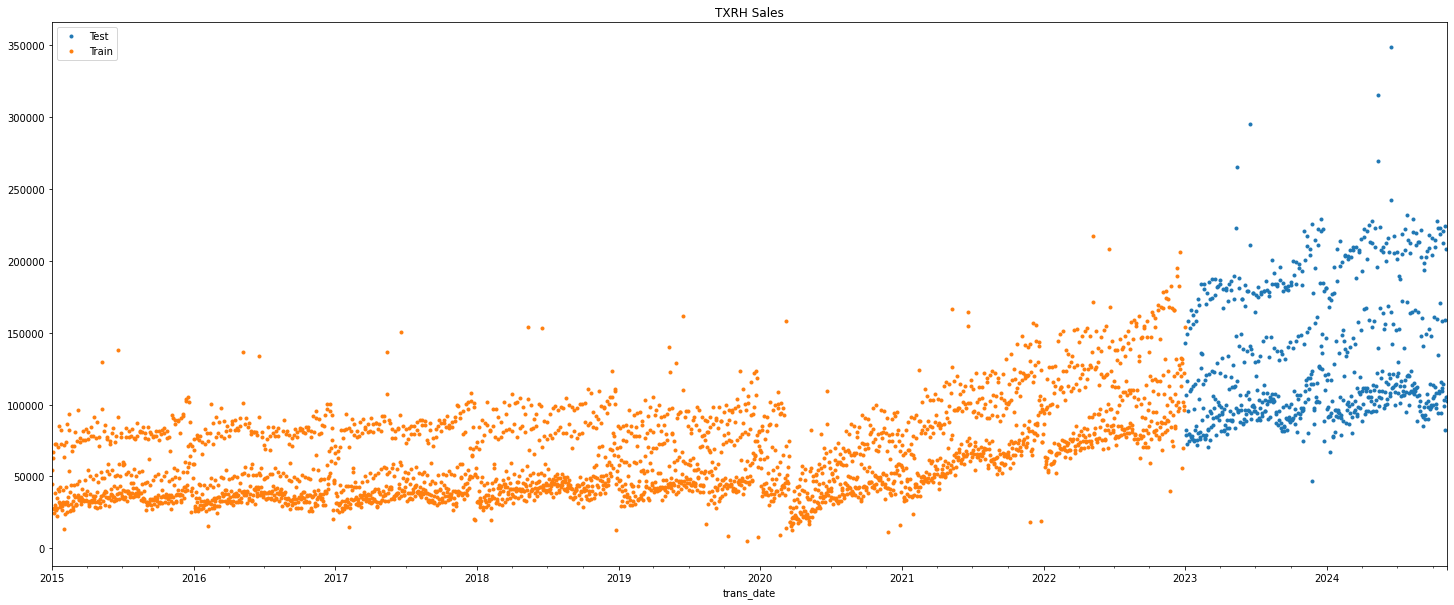

In [9]:
split_date_str = '2023-01-01'
split_date_dt = datetime.strptime(split_date_str, '%Y-%m-%d')

train = txrh_credit_spend[['spend_amount_usd']].loc[txrh_credit_spend.index < split_date_dt].copy()
test = txrh_credit_spend[['spend_amount_usd']].loc[txrh_credit_spend.index >= split_date_dt].copy()

test.rename(columns = {'spend_amount_usd' : 'Test'}, inplace = True)
train.rename(columns = {'spend_amount_usd' : 'Train'}, inplace = True)

test_train = pd.merge(test, train, left_index = True, right_index = True, how='outer').plot(figsize=(25,10), title = 'TXRH Sales', style = '.')
plt.show()

In [10]:
#prophet model requires format of: datetime column = ds, target = y
txrh_train_prophet = train.reset_index() \
    .rename(columns={'trans_date':'ds', 'Train':'y'})

txrh_test_prophet = test.reset_index() \
    .rename(columns={'trans_date':'ds', 'Test':'y'})

In [19]:
txrh_test_prophet.tail(5)

,ds,y
671,2024-11-02,223977.65
672,2024-11-03,208528.86
673,2024-11-04,105615.87
674,2024-11-05,102534.69
675,2024-11-06,105332.14


In [12]:
%%time
model = Prophet()
model.fit(txrh_train_prophet)

10:05:35 - cmdstanpy - INFO - Chain [1] start processing
10:05:37 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 3.09 s


In [13]:
txrh_test_fcst = model.predict(txrh_test_prophet)

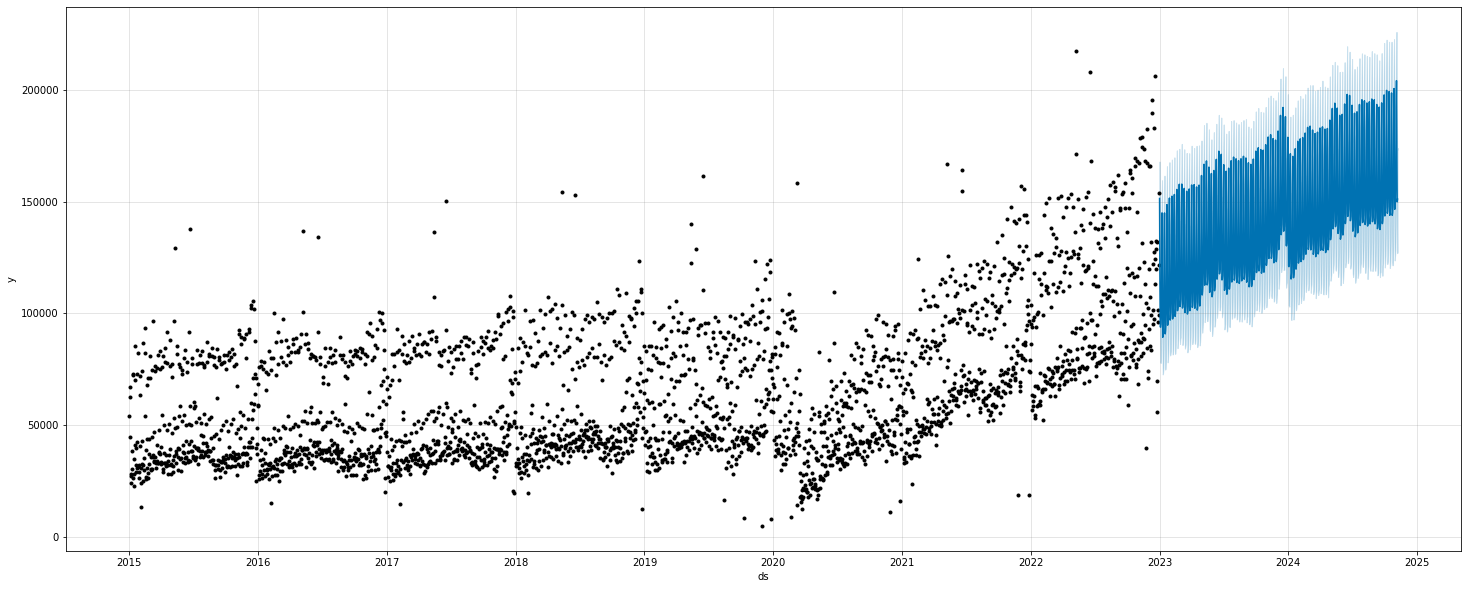

In [14]:
fig, ax = plt.subplots(figsize=(25,10))
fig = model.plot(txrh_test_fcst, ax = ax)
plt.show()

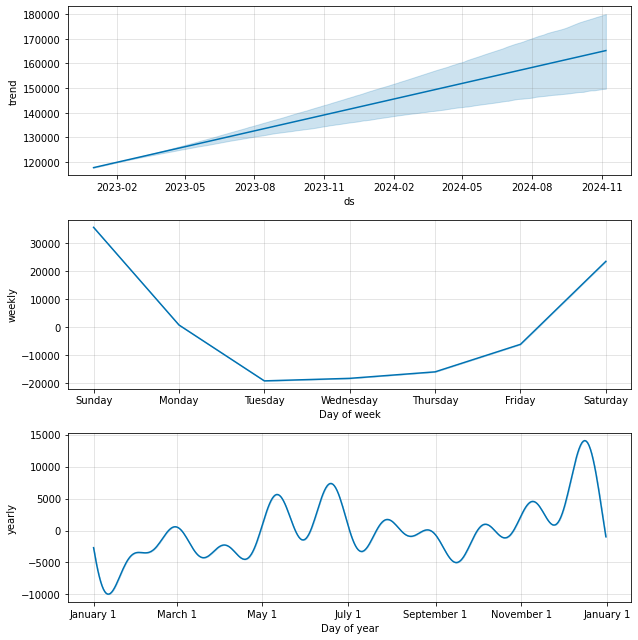

In [15]:
fig = model.plot_components(txrh_test_fcst)
plt.show()

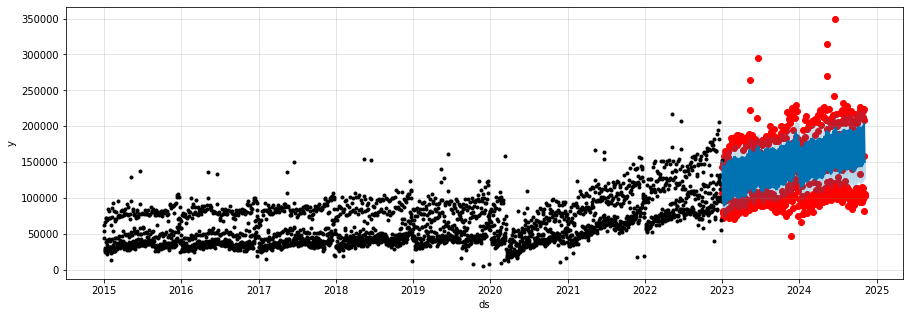

In [16]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test.index, test['Test'], color='r')
fig = model.plot(txrh_test_fcst, ax=ax)

In [17]:
fig = make_subplots()
test_plot = go.Scatter(x=test.index, y=test['Test'], fillcolor='red', name = 'Ground Truth')
fcst_plot = go.Scatter(x=txrh_test_fcst['ds'], y=txrh_test_fcst['yhat'], fillcolor='blue', name = 'Forecast')
fig.add_trace(test_plot)
fig.add_trace(fcst_plot)

fig.update_layout(
    title='Texas Roadhouse',
    title_x=0.5,
    xaxis_title="Date", 
    yaxis_title="Sales ($USD)"
)

fig.show()

In [30]:
np.sqrt(mean_squared_error(y_true=test['Test'],
                   y_pred=txrh_test_fcst['yhat']))

29952.558372219944

In [32]:
mean_absolute_error(y_true=test['Test'],
                   y_pred=txrh_test_fcst['yhat'])

25460.114401672476

In [34]:
mape(ground_truth=test['Test'],
                   prediction=txrh_test_fcst['yhat'])

21.39542161357701

,trans_date,yhat,spend_amount_usd
0,2015-01-01,NaN,54313.85
1,2015-01-02,NaN,44671.48
2,2015-01-03,NaN,62768.25
3,2015-01-04,NaN,66930.25
4,2015-01-05,NaN,28379.56


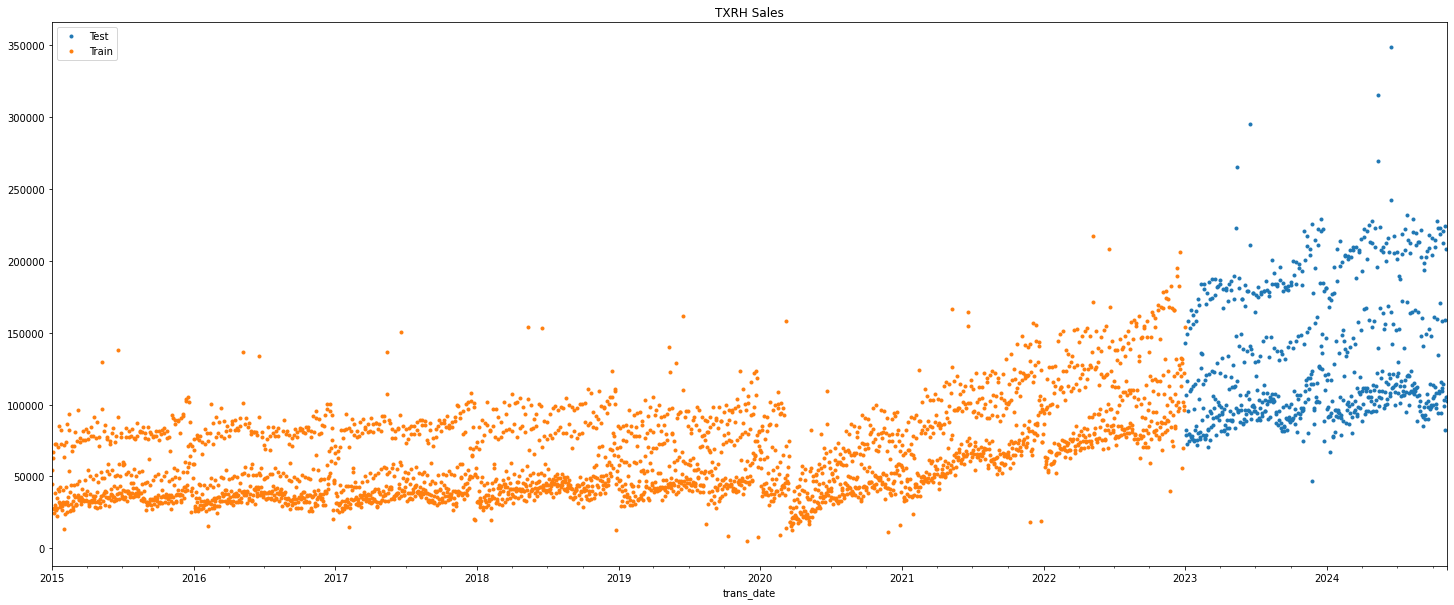

In [38]:
future = model.make_future_dataframe(periods=1095, freq='d', include_history=False)
forecast = model.predict(future)

In [40]:
forecast[['ds','yhat']].tail()

,ds,yhat
1090,2025-12-26,194447.857264
1091,2025-12-27,222810.075196
1092,2025-12-28,233595.739388
1093,2025-12-29,197260.010786
1094,2025-12-30,175863.739717


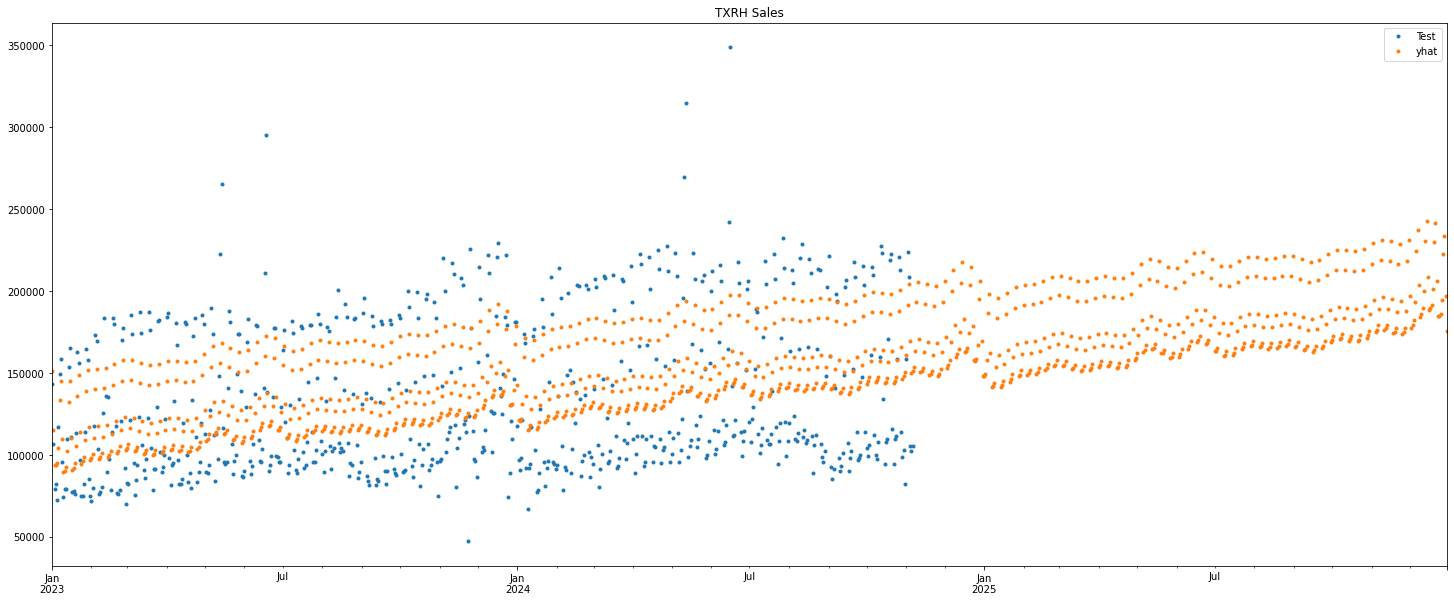

In [56]:
forecast_final = forecast[['yhat']]

test_forecast = pd.merge(test, forecast_final, left_index = True, right_index = True, how='outer').plot(figsize=(25,10), title = 'TXRH Sales', style = '.')

In [ ]:
final = pd.merge(txrh_test_fcst[['ds', 'yhat']], txrh_credit_spend.reset_index()[['trans_date', 'spend_amount_usd']], left_on = 'ds', right_on = 'trans_date', how='right')
final[['trans_date', 'yhat','spend_amount_usd']].head()